In [1]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np
from OutFunc import OutFunc
from ROOT import TMVA
import os

In [2]:
TMVA.Tools.Instance()

In [3]:
#Note we will use CrossValidation data file for hypertuning
trainingFile = ROOT.TFile("../modelInputData/trainData.root")
testFile = ROOT.TFile("../modelInputData/validData.root")

#Getting the TTree objects from input files
sigTrain = trainingFile.Get("sig")
bkgTrain = trainingFile.Get("bkg")
nSigTrain = sigTrain.GetEntries()
nBkgTrain = bkgTrain.GetEntries()

sigTest = testFile.Get("sig")
bkgTest = testFile.Get("bkg")
nSigTest = sigTest.GetEntries()
nBkgTest = bkgTest.GetEntries()

#GlobalEventWeights
sigWeight = 1.0
bkgWeight = float(nSigTrain)/float(nBkgTrain)

In [ ]:
#CASE 1 - MAX DEPTH (2, 5)
"""
Number of trees = 200 constant, others are default
"""
numIters = [2, 3, 4, 5]
errorRate = []

In [5]:
for iter in numIters:
    #Creating output file, factory object
    if not os.path.isfile(f"datasetsTuning/MaxDepth/datasetsTuning_MaxDepth{iter}/weights/tmvaTest_MaxDepth_{iter}_BDT.weights.xml"):
        print(f"Starting training for MaxDepth = {iter}")

        dataLoader = TMVA.DataLoader(f"datasetsTuning/MaxDepth/datasetsTuning_MaxDepth{iter}")
        outputFile = ROOT.TFile(f"outputTuning/MaxDepth/TMVA_MaxDepth_{iter}.root", "RECREATE")
        factory = TMVA.Factory(f"tmvaTest_MaxDepth_{iter}", outputFile, "")
        dataLoader.AddSignalTree(sigTrain, sigWeight, TMVA.Types.kTraining)
        dataLoader.AddBackgroundTree(bkgTrain, bkgWeight, TMVA.Types.kTraining)
        dataLoader.AddSignalTree(sigTest, sigWeight, TMVA.Types.kTesting)
        dataLoader.AddBackgroundTree(bkgTest, bkgWeight, TMVA.Types.kTesting)
        dataLoader.AddVariable("ADC_mean", 'F')
        dataLoader.AddVariable("nhits_min", 'F')
        dataLoader.AddVariable("entry_dist", 'F')
        dataLoader.AddVariable("exit_dist", 'F')
        dataLoader.AddVariable("docasqrx_max", 'F')
        dataLoader.AddVariable("docasqry_max", 'F')
        #Train the model first
        factory.BookMethod(dataLoader, TMVA.Types.kBDT,
                    "BDT", f"NTrees=200:MaxDepth={iter}:BoostType=AdaBoost")
        factory.TrainAllMethods()
        factory.TestAllMethods()
        factory.EvaluateAllMethods()
        outputFile.Close()
    else:
        print(f"Model for MaxDepth = {iter} already trained.")
    
    #Analysing results on training data
    dir = f"datasetsTuning/MaxDepth/datasetsTuning_MaxDepth{iter}/weights/"
    prefix = f"tmvaTest_MaxDepth_{iter}"
    name = "BDT"
    tCut = 0.0
    useVar = [False, True, True, True, True, True, True]

    testStat = OutFunc(name, dir, prefix, tCut, useVar)

    #Open Input File and get trees
    inputFile = ROOT.TFile("../modelInputData/validData.root")
    inputFile.ls()
    sig = inputFile.Get("sig")
    bkg = inputFile.Get("bkg")

    treeVec = [sig, bkg]

    nSig = 0
    nBkg = 0
    nSigInAcc = 0         #Inaccurately classified events counter
    nBkgInAcc = 0         #Inaccurately classified events counter
    tc = 0.0              #Decision cut

    #Loop over signal(i = 0) and background(i = 1)
    for i, tree in enumerate(treeVec):
        numEntries = tree.GetEntries()
        if i == 0:
            nSig = numEntries
        else:
            nBkg = numEntries
        
        print(f"Tree: {'sig' if i==0 else 'bkg'}, Entries: {numEntries}")

        for j in range(numEntries):
            tree.GetEntry(j)
            #Apply our Test statistic
            t = testStat.val(tree)

            if i == 0:  #Signal
                if t < tc:
                    nSigInAcc += 1
            else:       #Background
                if t > tc:
                    nBkgInAcc += 1
    
    #Finding the error rate
    error = (nSigInAcc + nBkgInAcc)/(nSig + nBkg)
    print(f"Error for MaxDepth {iter} = {error}")
    errorRate.append(error)
    #Closing inputfile
    inputFile.Close()

    

Model for MaxDepth = 2 already trained.
Tree: sig, Entries: 420370
Tree: bkg, Entries: 4804556
Error for MaxDepth 2 = 0.03052693952029177
Model for MaxDepth = 3 already trained.
Tree: sig, Entries: 420370
Tree: bkg, Entries: 4804556
Error for MaxDepth 3 = 0.031002161561713985
Model for MaxDepth = 4 already trained.
Tree: sig, Entries: 420370
Tree: bkg, Entries: 4804556
Error for MaxDepth 4 = 0.029385105167039686
                         : Booking "BDT" of type "BDT" from datasetsTuning/MaxDepth/datasetsTuning_MaxDepth2/weights//tmvaTest_MaxDepth_2_BDT.weights.xml.
                         : Reading weight file: datasetsTuning/MaxDepth/datasetsTuning_MaxDepth2/weights//tmvaTest_MaxDepth_2_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"
TFile**		../modelInputData/validData.root	
 TFile*		../modelInputData/validData

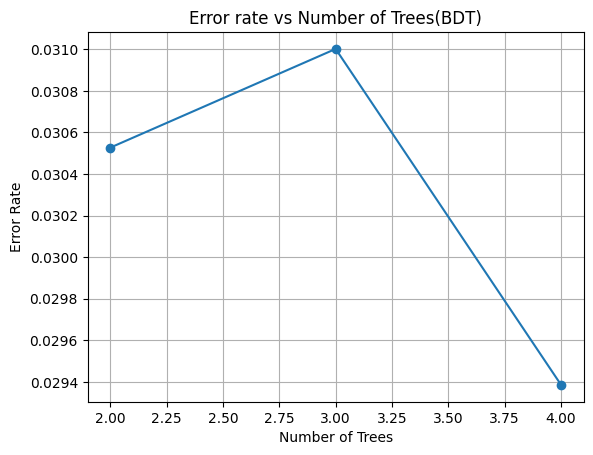

In [ ]:
%jsroot on
#Plotting error rates
plt.figure()
plt.plot(numIters, errorRate, marker = 'o')
#plt.xscale('log')
plt.xlabel("Number of Trees")
plt.ylabel("Error Rate")
plt.title("Error rate vs Number of Trees(BDT)")
plt.grid(True)
plt.show() 
